In [14]:
# Empecemos con los imports

from ase.build import molecule
from ase import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.optimize import BFGS, QuasiNewton
from ase.vibrations import Vibrations

from mace.calculators import mace_mp , MACECalculator
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

# Modelo MACE como una alternativa al DFT en la construcción de potenciales interatomicos

Daniel José Duque $^{1}$ , Tomas Uberney Goméz $^{1}$ 

$ ^{1}\textit{Instituto de Física, Universidad de Antioquia U de A, calle 70 No. 52-21, Medellín, Colombia} $

### Introducción

El proyecto busca abordar el problema del cálculo eficiente y preciso de las energías y fuerzas interatómicas en sistemas moleculares y materiales, una tarea fundamental en química computacional y física del estado sólido. Tradicionalmente, este tipo de cálculos se realiza mediante métodos ab initio ( cálculos de primeros principios ), como la Teoría del Funcional de la Densidad (DFT), los cuales, aunque altamente precisos, resultan extremadamente costosos en términos computacionales cuando se aplican a sistemas grandes o dinámicos. En respuesta a esta limitación, el modelo MACE (Multiplicative Atomic Cluster Expansion) propone una solución basada en aprendizaje profundo (Deep Learning), que permite aproximar la precisión del DFT con un costo computacional mucho menor.

El desarrollo de modelos como MACE representa un avance interdisciplinario clave entre la física, la química computacional y el aprendizaje estadístico. En un contexto científico y tecnológico, este tipo de modelos democratizan el acceso a simulaciones cuánticas de alta precisión, permitiendo estudiar materiales complejos, procesos catalíticos, o interacciones biológicas que antes requerían recursos de supercomputación. En particular este proyecto nace del interés de estudiar las propiedades  del cristal de beta-hematina, el cual es un dímero de ferriprotoporfirina IX (Fe(III)PPIX), cada monómero de hematina tiene la forma molecular aproximada de C34​H32​FeN4​O4, así el dímero se representa mediante C68​H62​Fe2​N8​O8​​ es decir un total de 148 átomos por dímero. Pagola et al. reportan un modelo donde por celda unitaria del cristal existen 2 dímeros (es decir 296 átomos por celda unitaria), ahora bien si se quisiese simular un cristal crecido se requiere de múltiplos enteros de estas celdas unitarias, elevando fuertemente el coste computacional de simular estas interacciones interatómicas por primeros principios. Al emplear MACE estamos refiriéndo nos a cálculos del orden de ~O(N), procesos que no demandan mucho coste computacional.

Así pues la comprensión de MACE como herramienta práctica para el desarrollo de calculos y simulaciones se ve como una hábilidad útil en el desarrollo de nuestra carrera profesional, de modo que se plantean una serie de metas en un primer acercamiento a esta MLIP:

- Aprender a usar MACE incorporado en ASE y así poder determinar las energías de nuestros sistemas atómicos y cómo deducir propiedades deseadas a partir de esta información.
- Entender el proceso del fine-tuning y cómo llevarlo a cabo a partir de datos de primeros principios
- Emplear MACE para el cálculo de propiedades elásticas del dímero de Beta-Hematina y su comparación cualitativa con un espectro IR de una muestra experimental. (Este objetivo depende del tiempo disponible)
- Entender el funcionamiento de MACE como GNN y MPNN, desde su funcionamiento como algoritmo, hasta su fase de entrenamiento como “learnable model” 


## Metodologia

### MACE como MLIP

MACE es una equivariance MPNN, es decir una red neuronal equivariante de intercambio de mensajes, este tipo de redes son redes basadas en gráfos, donde la estructura de los datos se representa mediante nodos y sus aristas correspondientes 

![texto alternativo](https://github.com/danielduque1/proyecto-AE/blob/bf8f6ae8f4ab2b6c4ef2f6b3e9d945260eeefef3/Entrega/Codigos/Imagenes/algoritmo_MPNN.jpg)

En este tipo de redes los features se asocian a los nodos $\sigma$ mediante tuplas, dichas tuplas cuentan con varias entradas posibles, primero, dentro de ellas se alamacenan 1. Los números atomicos de cada nodo, 2. sus coordenadas espaciales respecto a un sistema de referencia y 3. lo que se denomina como vector de features $\vec{h}$, este último aunque se denomine vector posee un caracter tensorial, pues primero tiene diferentes canales de información, así como se representa mediante bases de mayor rango (Esto con el fin de representar el acoplamiento de los estados cuanticos). Además tanto al nodo como al mensaje se les asocia una iteracción (correspondiente a la cantida de mensajes construidos y compartidos hasta dicho momento).

Una MPNN tiene un funcionamiento básico, se inicializa y posteriormente empieza a construir interacciónes entre sus elementos internos, estas interacciónes se pueden clasificar dependiendo del número de cuerpos que interactuen simultaneamente, estas son conocidas como mensajes. Tras que cada nodo construya si mensaje, procede a actualizar sus features mediante funciones de aprendizaje. 

Una vez recorrido un número de ciclos preestablecidos (Los autores comentan que 2 o 3 son más que suficientes), se procede a construir un mensaje de salida, este es el target de nuestra red (correspondiendo en este caso a la energía del estado elemental del sistema) y es un invariante, este target se obtiene mediante unas readout functions, que son nuevamente funciones de aprendizaje.

Con el fin de aproximar lo mejor posible la realidad se ha establecido que estas redes deven ser equivariantes, es decir sus features deben transformar de una manera adecuada frente a la acción de un grupo, en partícular es de especial interes el que se transformen bajo $O(3)$ 

![texto alternativo](./Imagenes/equivarianza.jpg)

Esta equivarianza se representa bajo las matrices $D$ generalizaciones del grupo sobre espacios vectoriales de mayor dimensión.

Así, MACE integra las MPNNs con la equivarianza a través de un ingenioso truco y es la construcción del mensaje pensandolo como un producto tensorial el cual da cuenta de la superposición del estado de unas bases que respetan precisamente la equivarianza sobre este grupo $O(3)$.

![texto alternativo](./Imagenes/MACE_MPNN.jpg)

Precisamente este producto tensorial es clave en la mejora sustancial del tiempo de computo de MACE, pues implica que no debemos jerarquizar las interacciones, de hecho permite precisamente autointeracciones de muchos ordenes, asi el computo se reduce realmente a un pequeño número de productos matriciales.

Dentro de la construcción del mensaje se emplean unas bases radiales derivadas de las funciones de Bessel y ademas incorporamos los Armonicos esfericos, acoplados por los coeficiente de Clebsh-Gordan generalizado. A lo largo de la construcción del mensaje se emplean diversos coeficiente $W$ que son funciones de aprendizaje.

La salida del sistema es un invariante, pues representa la energia, para esto se emplean unas read-out functions que unicamente emplean el componente $L=0$ que corresponde precisamente a los invaraintes del grupo (escalares). La salida se presenta como una expansión donde cada termino esta asociado a uno de los pasos (iteraciones de la red). Para la última iteración el readout se obtiene mediante un multilayer-perceptron (fullyconnected neural network) y para los pasos  intermedios se se emplean unos pesos aprendidos.

### ¿Cómo se emplea MACE?

Desde la perspectiva del usuario final MACE es un calculador de las energías del estado base de un sistema molecular, como calculador se puede asociar a diferentes softwares de simulaciónes atomicas, principalmente esta pensado para incorporarse en la libreria de Python ASE (Atomic Similation Enviroment), pero tambien se puede emplear en LAMMPS o en OpenMM (Para su implementación consultar en https://mace-docs.readthedocs.io/en/latest/guide/openmm.html), de modo que trabajar con MACE se puede dividir unicamente en 2 procesos,  **Entrenamiento** y **MACECalculator**. 

El primero se divide en 2 categorias, un entrenamiento desde cero, donde los parametros del modelo se inicializan aleatoriamente y se entrena a partir de un dataset de preferencia o tambien se encuentra lo que se conoce como fine-tuning, este mismo posee un modo default (naive) donde se reinicia el entrenamiento partiendo no de parametros aleatorios si no de los parametros de alguno de los modelos fundacionales, además se encuentra el multihead fine-tuning donde se entrena un modelo en paralelo con dos datasets: el de interes y un replay dataset (dataset basado en los datos con el que se entreno originalmente el modelo fundacional o en su defecto el modelo propio). En general el proceso de Entrenamiento requiere de una limpieza/elección de los datos con los que se entrenara el modelo, en partícular es importante tener un set de datos balanceado, donde además se incluyan los calculos energeticos de los atomos aislados, un ejemplo de un data set se da a continuación:     

Observemos que se encuentran datos como el número de átomos por compuesto, su número atomico, red, posiciones, fuerzas, energias, dipolo, condiciones de frontera e incluso momentos magneticos, incluso se podria incluir los datos del esfuerzo (stress). Para los atomos aislados es importante añadirles el categorico:

    config_type=IsolatedAtom

Este le da a entender a la rutina de entrenamiento que se tratan de atomos y no de moleculas, esto pues la naturaleza de MACE como MPNN require de intercambios de mensajes entre varios nodos, por lo que un nodo solitario conllevaria a errores de calculo.

El segundo proceso referente a **MACECalculator** es precisamente emplear el modelo ya entrenado (sea por uno mismo o alguno de los modelos fundacionales) como calculador de energías de un sistema atómico, permitiendo entonces llevar a cabo simulaciones donde se requiere calcular la energía de cierta configuración tras cada iteración. De esta energía se puede derivar la fuerza, mediante el gradiente respecto a las coordenadas del i-esimo nodo, es importante señalar que estos primeros modelos fundacionales MACE MP 0 unicamente entregan esta energía por lo que los entornos de simulación atomica solo pueden realizar calculos que dependan explicitamente de la energía o de las fuerzas.

Teniendo en cuenta estos paradigmas se abordo entonces en el proyecto 4 pasos correspondientes a cada uno a los objetivos planteades en la introducción:

1. Se emplea MACE como calculador de ASE en simulaciónes básicas, donde se le compara con métodos ab initio (DFT) empleando GPAW calculator. Entre estas simulaciones básicas esta la curva potencial entre dos atomos identicos, la relajación de sistemas moleculares como el agua ($H_2O$), calculo de adsorción y vibraciones de moleculas sencillas.

2. Entrenamientos de Modelos MACE siguiendo las pautas de los autores, evalacuación de su rendimiento en comparación a calculos empleados con XTB, para esto se emplea dataset de electrolitos y se observa dinamica de Langevin (Exposición de las celdas a reservorios de temperatura constante) sobre elementos del dataset.

3. Entrenamientos de modelos mediante fine-tuning para la predicción de propiedades sobre la celda unitaria de $\beta$-Hematina, principalmente energía de estado base, relajación de la molécula y frecuencias propias de vibración.

4. Abordar parte del componente teorico del modelo, guiandonos del paper de Batia et al. y de las guias establecidas en la documentación de MACE https://colab.research.google.com/drive/1AlfjQETV_jZ0JQnV5M3FGwAM2SGCl2aU

Para hacer realidad todos estos objetivos se hizo uso de numpy, matplotlib, ASE, MACE-Torch, Torch y GPAW. Torch no se uso explicitamente pero se considera importante su mención pues el modelo MACE corre encima de torch (tambien se emplea o3nn con el fin de establecer las bases y las equivarianzas del grupo).

## Resultados

### ASE calculator:

Como ya se establecio el objetivo inicial de MACE como MLIP es el predecir la energía de sistemas atómicos, pero para poder hacer esto debemos importarla como un Calculator.

El modulo `mace.calculators` trae incorporado dentro de si mismo 3 calculadores pre-entrenados y el elemento general MACECalculator

    "MACECalculator",
    "LAMMPS_MACE",
    "mace_mp",
    "mace_off",
    "mace_anicc"

Particularmente `mace-mp` hace referencial al modelo fundacional MACE MP 03b, el cual es el modelo principal entrenado en base de los datasets de Material Proyect, cabe mencionar que estos modelos preentrenados vienen en diversos tamaños donde, podemos aumentar el tiempo computacional a cambio de una mejor precisión de calculo, existiendo así los modelos `"small"`, `"medium"` y `"large"`.  

In [3]:
# Prueba 1: Optimización y vibraciones molecula de N2
import time
import os

ruta = os.getcwd()
print("Ruta actual:", ruta)

N2 = Atoms('N2', positions=[[0, 0, -1], [0, 0, 1]])
N2.center(vacuum=3.5)

calc_mace = mace_mp(model="medium", default_dtype="float64", device="cpu")
N2.calc = calc_mace 

t_start = time.time()
opt_N2 = BFGS(N2,trajectory= ruta + "/trayectorias/traj_n2.traj")
opt_N2.run(fmax=0.01)
t_finish = time.time()
print(f"Tiempo de optimización N2: {t_finish - t_start} segundos")

Ruta actual: e:\Aprendizaje_Est\proyecto-AE\Entrega\Codigos
Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
      Step     Time          Energy          fmax
BFGS:    0 10:31:33       -7.229483        5.836655
BFGS:    1 10:31:34       -8.487903        8.847669
BFGS:    2 10:31:35      -13.086761       13.422398
BFGS:    3 10:31:35      -15.665890       15.585467
BFGS:    4 10:31:35      -15.403998       10.355411
BFGS:    5 10:31:35      -16.081852        5.147366
BFGS:    6 10:31:35      -16.128895        5.835022
BFGS:    7 10:31:35      -16.218133        1.371004
BFGS:    8 10:31:35      -16.225105        0.234832
BFGS:    9 10:31:35      -16.225300        0.015188
BFGS:   10 10:31:35      -16.225301        0.000140
Tiempo de optimización N2: 2.7126071453094482 segundos


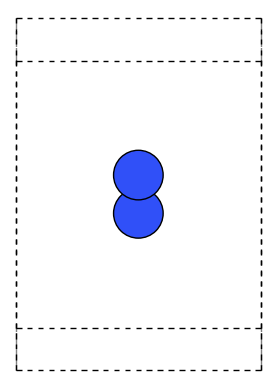

Energía final de N2 optimizado: -16.22530089514988
Fuerzas finales de N2 optimizado: [[ 0.          0.          0.00014034]
 [ 0.          0.         -0.00014034]]
Distancias de N2 optimizado: [[0.         1.11238331]
 [1.11238331 0.        ]]


In [8]:
traj = read(ruta + "/trayectorias/traj_n2.traj", ':')   # dos puntos = leer toda la trayectoria
view(traj) 

fig, ax = plt.subplots()
plot_atoms(N2, ax, rotation=('-80x,0y,0z'))
ax.set_axis_off()
plt.show()

print("Energía final de N2 optimizado:", N2.get_potential_energy())
print("Fuerzas finales de N2 optimizado:", N2.get_forces())
print("Distancias de N2 optimizado:", N2.get_all_distances(mic=True))

In [18]:
vib_N2 = Vibrations(N2, name=ruta + '/vib_N2')
vib_N2.run()
vib_N2.summary(log=ruta+'/txt/N2_vib_summary.log')

Frecuencias vibracionales de N2 (cm^-1): [8.32020949e-06 1.70139518e-07 1.51052175e+01 1.51052175e+01
 2.34735123e+03]


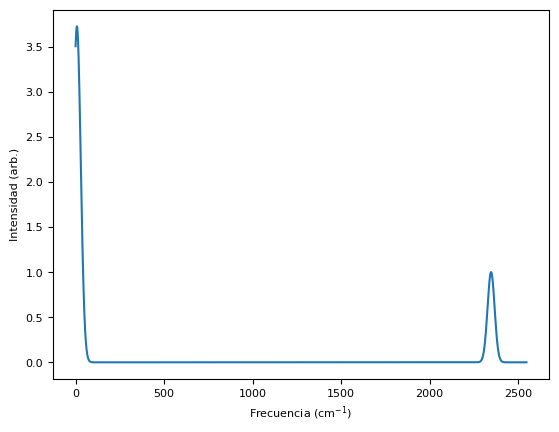


[0.00000000e+00+8.32020949e-06j 0.00000000e+00+0.00000000e+00j
 1.70139518e-07+0.00000000e+00j 1.51052175e+01+0.00000000e+00j
 1.51052175e+01+0.00000000e+00j 2.34735123e+03+0.00000000e+00j]


In [22]:
freqs = np.abs(np.array(vib_N2.get_frequencies()))
freqs = freqs[freqs > 0]

print("Frecuencias vibracionales de N2 (cm^-1):", freqs)

x = np.linspace(0, freqs.max() + 200, 4000)
sigma = 20.0

spec = sum(np.exp(-(x - f)**2 / (2*sigma**2)) for f in freqs)

plt.plot(x, spec)
plt.xlabel("Frecuencia (cm$^{-1}$)")
plt.ylabel("Intensidad (arb.)")
plt.show()

print(f"\n{np.array(vib_N2.get_frequencies())}")

Notemos que este sistema solo deberia tener un modo de vibración, correspondiente según los calculos a 2347 $\text{cm}^{-1}$, donde realmente los primeros modos son muy cercanos a cero o imaginarios, esto es debido al método númerico empleado para la determinación de las frecuencias. La energía final corresponde a los -16.225 eV, con una separación entre los átomos de 1.11238331 A.

Ruta actual: e:\Aprendizaje_Est\proyecto-AE\Entrega\Codigos
Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
      Step     Time          Energy          fmax
BFGS:    0 12:35:31      -10.329478        8.103797
BFGS:    1 12:35:31      -12.156930        7.060060
BFGS:    2 12:35:32      -14.091118        0.839777
BFGS:    3 12:35:32      -14.114123        0.741929
BFGS:    4 12:35:32      -14.158107        0.279235
BFGS:    5 12:35:32      -14.160178        0.095422
BFGS:    6 12:35:32      -14.160284        0.017217
BFGS:    7 12:35:32      -14.160290        0.000616
Tiempo de optimización H2O: 1.4480903148651123 segundos



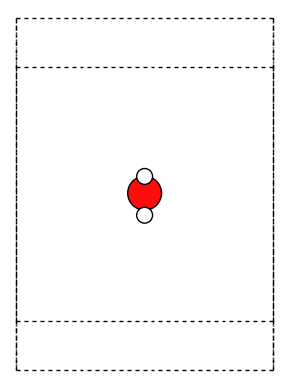

Energía final de H2O optimizado: -14.160290459138405
Fuerzas finales de H2O optimizado: [[ 0.00000000e+00 -2.80405290e-05 -6.15779773e-04]
 [ 0.00000000e+00  5.60810579e-05  0.00000000e+00]
 [ 0.00000000e+00 -2.80405290e-05  6.15779773e-04]]
Distancias de H2O optimizado: [[0.         0.97295025 1.53446419]
 [0.97295025 0.         0.97295025]
 [1.53446419 0.97295025 0.        ]]
Ángulos de H2O optimizado: [104.10275713  37.94862143  37.94862143]
Frecuencias vibracionales de H2O (cm^-1): [6.00596233e+01 7.21579201e-01 3.74897626e-02 3.56537164e-01
 2.11734249e+01 2.73088390e+01 1.59962855e+03 3.59023503e+03
 3.73461956e+03]


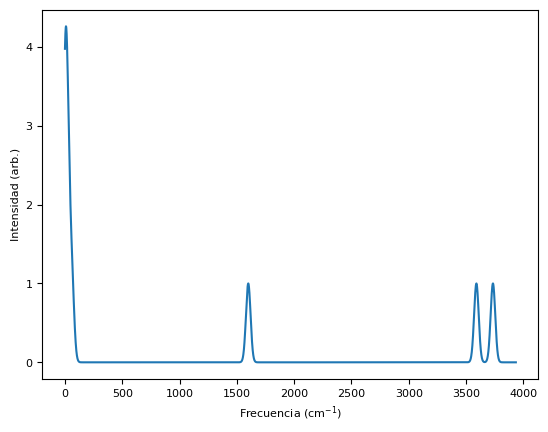

In [9]:
# Prueba 2: optimización y vibraciones molécula de H2O

import os

ruta = os.getcwd()
print("Ruta actual:", ruta)

H2O = Atoms('HOH', positions=[[0, 0, -1], [0, 1, 0], [0, 0, 1]])
H2O.center(vacuum=5.0)

calc_mace = mace_mp(model="medium", default_dtype="float64", device="cpu")
H2O.calc = calc_mace 

t_start = time.time()
opt_H2O = BFGS(H2O,trajectory= ruta + "/trayectorias/traj_h2o.traj")
opt_H2O.run(fmax=0.01)
t_finish = time.time()
print(f"Tiempo de optimización H2O: {t_finish - t_start} segundos\n")

traj = read(ruta + "/trayectorias/traj_h2o.traj", ':')   # dos puntos = leer toda la trayectoria
view(traj) 

fig, ax = plt.subplots()
plot_atoms(H2O, ax, rotation=('-80x,0y,0z'))
ax.set_axis_off()
plt.show()

print("Energía final de H2O optimizado:", H2O.get_potential_energy())
print("Fuerzas finales de H2O optimizado:", H2O.get_forces())
print("Distancias de H2O optimizado:", H2O.get_all_distances(mic=True))
print("Ángulos de H2O optimizado:", H2O.get_angles([(0,1,2),(1,0,2),(1,2,0)]))

vib_H2O = Vibrations(H2O, name=ruta + '/vib_H2O')
vib_H2O.run()
vib_H2O.summary(log=ruta+'/txt/H2O_vib_summary.log')

freqs = np.abs(np.array(vib_H2O.get_frequencies()))
freqs = freqs[freqs > 0]
print("Frecuencias vibracionales de H2O (cm^-1):", freqs)
x = np.linspace(0, freqs.max() + 200, 4000)
sigma = 20.0
spec = sum(np.exp(-(x - f)**2 / (2*sigma**2)) for f in freqs)
plt.plot(x, spec)
plt.xlabel("Frecuencia (cm$^{-1}$)")
plt.ylabel("Intensidad (arb.)")
plt.show()

Como punto de comparación el calculo de la geometria con GPAW establece una energía de -13.688792509044024 eV, en un Optimization time:  7.016371250152588  seconds, además con unos ángulos de:
    Ángulos de H2O optimizado: [103.45875   38.270625  38.270625]

Para comparar el tiempo de optimización en el caso de MACE MP 0 "medium" con float64 fue de:
    Tiempo de optimización H2O: 0.7866771221160889 segundos

Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/20231210mace128L0_energy_epoch249model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
      Step     Time          Energy          fmax
BFGS:    0 12:36:51     -133.229211        4.337867
BFGS:    1 12:36:51     -132.831292        9.675004
BFGS:    2 12:36:51     -133.278564        1.529989
BFGS:    3 12:36:51     -133.286135        0.728495
BFGS:    4 12:36:52     -133.289120        0.462608
BFGS:    5 12:36:52     -133.300773        0.496379
BFGS:    6 12:36:52     -133.302852        0.256450
BFGS:    7 12:36:53     -133.303144        0.039203
BFGS:    8 12:36:53     -133.303149        0.003693
BFGS:    9 12:36:53     -133.303149        0.000061
Tiempo de optimización N2 sobre Cu(111): 2.8969030380249023 segundos
Adsorption energy: 0.4098570818694043
Initial slab forces := [[-5.77608707e-16 -2.74519990e-16  2.18665912e-01]
 [ 5.81945516e-17  1.24802512e-15  2.18665912e-01]
 [-1.18557508e-16 -1.39428399e-16  2.18665912e-01]
 [-3.89770681e-17 -8.01225405e-17  2.18665912e-01]
 [ 6.14130622e-16  1.74491498e-15  2.18665912e-01]
 [ 1.52

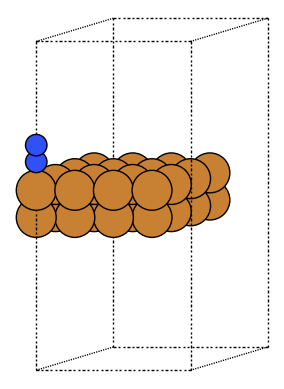

In [11]:
# Prueba 3: Adsorción de N2 sobre superficie de Cu(111)

from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms

calculo = mace_mp(model="small", device="cpu", default_dtype="float64")

h = 1.85
d = 1.10

slab = fcc111('Cu', size=(4, 4, 2), vacuum=10.0)

slab.calc = calculo
e_slab = slab.get_potential_energy()
f_slab = slab.get_forces()

molecule = Atoms('2N', positions=[(0.0, 0.0, 0.0), (0.0, 0.0, d)])

molecule.calc = calculo
e_N2 = molecule.get_potential_energy()
f_N2 = molecule.get_forces()

add_adsorbate(slab, molecule, h, 'ontop')
constraint = FixAtoms(mask=[a.symbol != 'N' for a in slab])
slab.set_constraint(constraint)

time_start = time.time()
dyn = BFGS(slab, trajectory='E:/Aprendizaje_Est/proyecto-AE/Entrega/Codigos/trayectorias/N2Cu.traj')
dyn.run(fmax=0.0005)
time_end = time.time()

print(f"Tiempo de optimización N2 sobre Cu(111): {time_end - time_start} segundos")
print('Adsorption energy:', e_slab + e_N2 - slab.get_potential_energy())

print(f"Initial slab forces := {f_slab}")
print(f"Initial N2 forces := {f_N2}")

traj = read('E:/Aprendizaje_Est/proyecto-AE/Entrega/Codigos/trayectorias/N2Cu.traj', ':')   # dos puntos = leer toda la trayectoria
view(traj)

fig, ax = plt.subplots()
plot_atoms(traj[-1], ax, rotation=('-80x,0y,0z'))
ax.set_axis_off()
plt.show()


Note especialmente que:
- Tiempo de optimización N2 sobre Cu(111): 2.751889705657959 segundos
- Adsorption energy: 0.4098570818694043

Esta energia de adsorción implica que hubo un proceso negativo, es decir la placa repelio a la molecula de N2, pues la configuración menos energetica implico aumentar la distancia respecto a la placa.

Este es el primer ejemplo donde realmente el calculo de MACE empieza a ser bastante más veloz, solo en el calculo de la energía de la placa se tomo un tiempo:

- Tiempo calculo placa sola: 102.47657799720764

- tiempo de optimización: 1492.6199061870575

- Energía de adsorción (eV): 2.3027484244729948

Acá la diferencia de computo es abismal, la simulación tomo en torno a los 25 minutos para ejecutarse exitosamente. Cabe resltar que el script tal vez resulte no ser el más optimo (Se desarrollo empleando gpt 5.1, pues GPAW requiere reajustar el calculador debido a las perdidas de simetría en el proceso de dinámica).

### Entrenando un modelo MACE

Para esta sección del desarrollo nos guiamos principalmente en lo establecido por los autores Batatia et al. en la documentación de MACE, además de obtener recomendaciones en el artículo de Liu X. et al. (donde establece pautas y recomendaciones para el proceso de fine-tuning de MLIP's en general, pero especialmente de MACE-MP-03b)

Como se estableción previamente el primer paso para un correcto entrenamiento esta en la elección de un buen dataset, donde se predisponga de las configuraciones geometricas, fuerzas, energías, dipolos, esfuerzos y momentos magneticos, además de que se debe incorporar los atomos aislados con sus niveles E0 de referencia, todo esto calculado mediante metodos ab initio (DFT), en particular es de especial importancia que los calculos originales se realicen empleando el mismo método para todos los elementos del dataset, el no hacerlo puede llevar a discrepancias y aumento de errores, especialmente debido a posibles desfaces en los niveles de referencia o en los calculos del dipolo/momento pues estos dependen de la geometria (sistema de referencia). 

Así pues para llevar a cabo el entrenamiento de un modelo MACE, se establecio la rutina `run_train.py` presentente en el paquete `mace.cli` dicha rutina requiere una serie de parametros los cuales deben ser entregados para poder ejecutar finalmente el entrenamiento:

In [ ]:

python <mace_repo_dir>/mace/cli/run_train.py \
    --name="MACE_model" \
    --train_file="train.xyz" \
    --valid_fraction=0.05 \
    --test_file="test.xyz" \
    --config_type_weights='{"Default":1.0}' \
    --E0s='{1:-13.663181292231226, 6:-1029.2809654211628, 7:-1484.1187695035828, 8:-2042.0330099956639}' \
    --model="MACE" \
    --hidden_irreps='128x0e + 128x1o' \
    --r_max=5.0 \
    --batch_size=10 \
    --max_num_epochs=1500 \
    --swa \
    --start_swa=1200 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --restart_latest \
    --device=cuda \

Cabe mencionar que los procesos de Fine Tuning se realizan empleando el mismo script, pero se le deben agregar algunas banderas extra

    --foundation_model="small"
    --multiheads_finetuning=False
    --pt_train_file
    --num_samples_pt: 3000
    --filter_type_pt: combinations

Estas banderas son requeridas para establecer que es un proceso de fine tuning, en particular se debe establece un `foundation_model` y `multiheads_finetuning` permite determinar el paradigma de entrenamiento, un valor de True require además establecer un dataset que se conoce como **"replay"**, este es un fragmento del dataset del modelo fundacional, el cual entrena una cabeza que se denomina "pt_head" la cual impide lo que los autores denominan como un "catastrophic forgetting", esto haciendo referencia a una perdida de la precisión del modelo al ajustarse demasiado con los nuevos datos, perdiendo los parametros del modelo fundacional, de hecho, este paradigma es el recomendado por los autores (Batatia et al.), pero en nuestra practica dio algunos problemas (es bastante más demorado de entrenar) y por alguna razón el RMSE de la default head es muy alta (por lo menos en el valor entregado por la rutina de entrenamiento), así que suponemos falta de comprensión del método. Liu X. et al. emplean el dafault finetuning para el entrenamiendo de sus modelos.

Respecto a los hiper-parametros, los autores recomiendan ajusta `num_channels`,`max_L` (Simetria del mensaje), `r_max` y por el contrario recomiendan no mover `num_interactions`, `correlation`, `max_ell` (Resolución ángular). En particular Lui X. recomienda "max_L = 2"

A continuación se presenta un archivo .yml para la configuración del entrenamiento

In [ ]:
%%writefile config/config-02.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace01"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "data/solvent_xtb_train_200.xyz"
valid_fraction: 0.10
test_file: "data/solvent_xtb_test.xyz"
energy_key: "energy_xtb"
forces_key: "forces_xtb"
device: cuda
batch_size: 10
max_num_epochs: 100
swa: True
seed: 123

El siguiente script permite empezar con el entrenamiento de un modelo desde python sin recurrir a la bash/shell

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

para iniciar ejecutar:

    train_mace("config/config-02.yml")

Los procesos de entrenamiento se realizaron en la nube empleando la opción T4 que otorga collab para el uso de GPU's. La siguiente figura muestra la salida del sistema tras un entrenamiento

![texto alternativo](./Imagenes/captura_entrenamiento.png)


El entrenamiento y test del modelo se realizan y se entienden bastante bien con los notebooks adjuntos:

https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX
https://colab.research.google.com/drive/1oCSVfMhWrqHTeHbKgUSQN9hTKxLzoNyb

En estos se entrenan modelos a partir de un dataset de electrolitos liquidos, y se somete a una simulación de Langevin (exposición del electrolito a un reservorio con una temperatura fija alta)


In [15]:
traj = read('E:\Aprendizaje_Est\proyecto-AE\Entrega\Codigos\mace03_md.xyz', ':')
view(traj)

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\danie\AppData\Local\Temp\ipykernel_48824\413934871.py:1: SyntaxWarning: invalid escape sequence '\A'
  traj = read('E:\Aprendizaje_Est\proyecto-AE\Entrega\Codigos\mace03_md.xyz', ':')


<Popen: returncode: None args: ['c:\\Users\\danie\\AppData\\Local\\Programs\...>

### Predicciones sobre celda unitaria $\beta$-hematina

Como establecimos, una de las motivaciones iniciales respecto al aprendizaje de MACE era implementarlo en calculos de propiedades del cristal de $\beta$-hematina, en particular para este proyecto nos restringimos a la determinación de los modos de vibración de una celda unitaria, para esto empleamos MACE-MP-03b mediano sin modificar, entrenamos un modelo MACE desde cero con parametros aleatorios y realizamos fine-tuning al modelo MACE-MP-03b small bajo los dos paradigmas ya explicados. Con esto y usando el método `vibrations` incorporado en ASE procedimos a realizar unos calculos y estimaciones cualitativas de los modos de vibración y del espectro infrarrojo IR del cristal, además comparamos con un espectro real tomado con una muestra del cristal sintetizado en un medio acuoso. 

Primero establezcamos los modelos empleados:

In [ ]:
# Corresponde al modelo Re - trained

%%writefile config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace01"
model_dir: "Model"
log_dir: "Model"
checkpoints_dir: "Model"
results_dir: "Model"
train_file: "data/train_data.xyz"
valid_fraction: 0.10
# test_file: "data/solvent_xtb_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
device: cuda
batch_size: 10
max_num_epochs: 100
swa: True
seed: 123

In [ ]:
# Fine Tuned Default 

%%writefile config-02.yml

model: "MACE"
stress_weight: 0.0
forces_weight: 10.0
energy_weight: 1.0
foundation_model: "small"
multiheads_finetuning: False
name: "default_finetuned_MACE"
model_dir: "Model"
log_dir: "Model"
checkpoints_dir: "Model"
results_dir: "Model"
train_file: "data/train_data.xyz"
valid_fraction: 0.10
# test_file: "data/solvent_xtb_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
device: cuda
batch_size: 10
max_num_epochs: 100
num_samples_pt: 300
swa: True
seed: 345

In [ ]:
# Fine Tuned Multihead

%%writefile config-03.yml

model: "MACE"
stress_weight: 0.0
forces_weight: 10.0
energy_weight: 1.0
foundation_model: "small"
multiheads_finetuning: True
name: "multihead_finetuned_MACE"
model_dir: "Model"
log_dir: "Model"
checkpoints_dir: "Model"
results_dir: "Model"
pt_train_file: "mp"
atomic_numbers: "[1, 6, 7, 8, 26]"
train_file: "data/train_data.xyz"
valid_fraction: 0.10
# test_file: "data/solvent_xtb_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
device: cuda
batch_size: 10
max_num_epochs: 100
num_samples_pt: 300
swa: False
seed: 345
filter_type_pt: combinations

Una vez con los modelos preparados se ejecuto el siguiente script para la obtención del espectro, la energía en el estado relajado y la Zero point energy.

In [ ]:
atoms = read("E:\Aprendizaje_Est\proyecto-AE\Entrega\datos\dataset_hemina_big.xyz", index=0)
view(atoms)
# atoms = molecule("H2O")	

# calc = mace_mp(model="medium", dispersion=False, default_dtype="float64", 
# 	#device='cuda', 
# 	txt="output-mace.txt")
#pt_head
calc = MACECalculator(model_paths="E:\Aprendizaje_Est\proyecto-AE\Entrega\Modelos\multihead_finetuned_MACE.model", device="cpu", default_dtype="float64",head="pt_head")

atoms.calc = calc

opt = BFGS(atoms, trajectory='Entrega/Codigos/trayectorias/MHpt_train_opt.traj', logfile='Entrega/Codigos/trayectorias/MHpt_train_opt.log')
opt.run(fmax=0.05)
print(atoms.get_potential_energy())

vib = Vibrations(atoms,name='Entrega/Codigos/vib_MHpt_train')
vib.run()
vib.summary(log='Entrega/Resultado/vib_summary_MHpt_train.log')

freqs = np.abs(np.array(vib.get_frequencies()))
freqs = freqs[freqs > 0]

x = np.linspace(0, freqs.max() + 200, 4000)
sigma = 20.0

spec = sum(np.exp(-(x - f)**2 / (2*sigma**2)) for f in freqs)

plt.plot(x, spec)
plt.title("Espectro de vibraciones - Hemina (pt_head Finetuned)")
plt.xlabel("Frecuencia (cm$^{-1}$)")
plt.ylabel("Intensidad (arb.)")
plt.show()

print("Frecuencias (cm^-1):", freqs)
print(f"frec originales: {vib.get_frequencies()}")

<!-- Notemos que el sistema solo deberia tener 1 modo de vibración, este corresponde a 2347 $\text{cm}^{-1}$, las demas vibraciones presentes corresponden a numeros cercanos a cero o vibraciones imaginarias, esto se debe en parte a que estamos calculando el hessinao a partir de estiramientos manuales en todas las direcciones. -->

Respecto a los resultados se obtuvieron los siguientes espectros:

![texto alternativo](../Espectro_IR_real.png)

Como referencia se presenta primero el espectro real de una muestra crecida en un medio acuoso.

![texto alternativo](../Espectro_MP0.png)

Este corresponde al espectro obtenido empleando MACE-MP-03b

![texto alternativo](../Espectro_RT.png)

Espectro del modelo entrenado desde cero.

![texto alternativo](../Espectro_Def.png)

Espectro obtenido con el default (naive) fine-tuning

![texto alternativo](../Espectro_MH_Def.png)

Espectro obtenido con el modelo multihead

![texto alternativo](../espectro_DFT.png)


- Modelo Re-train: -996.950532 eV
    - Zero-point energy: 18.526 eV

- Default: -984.2421790079545 eV
    - Zero-point energy: 24.203 eV

- MP 03b: -972.623865 eV
    - Zero-point energy: 28.748 eV

- DFT: aprox -984.178364 eV
    - Zero-point energy: 30.490 eV

## Entendimiento teorico:

Debido a que la naturaleza del proyecto es entender el funcionamiento de MACE, como resultado explícito se escribe lo entendido, de tal manera que quede detallado la apropiación de los conceptos de forma profunda del método, tanto teórico como computacional.

Para empezar se dan los detalles básicos donde está simentada la teoría de MACE, en este caso implementado en ASE.

Para iniciar se debe tener en cuenta su definición formal y a partir de esto se hace el desarrollo de su estructura interna.

Podemos ver las siguientes imágenes que describe el proceso básico de MACE a continuación, tomado de un tutorial teórico incluido en documentación.

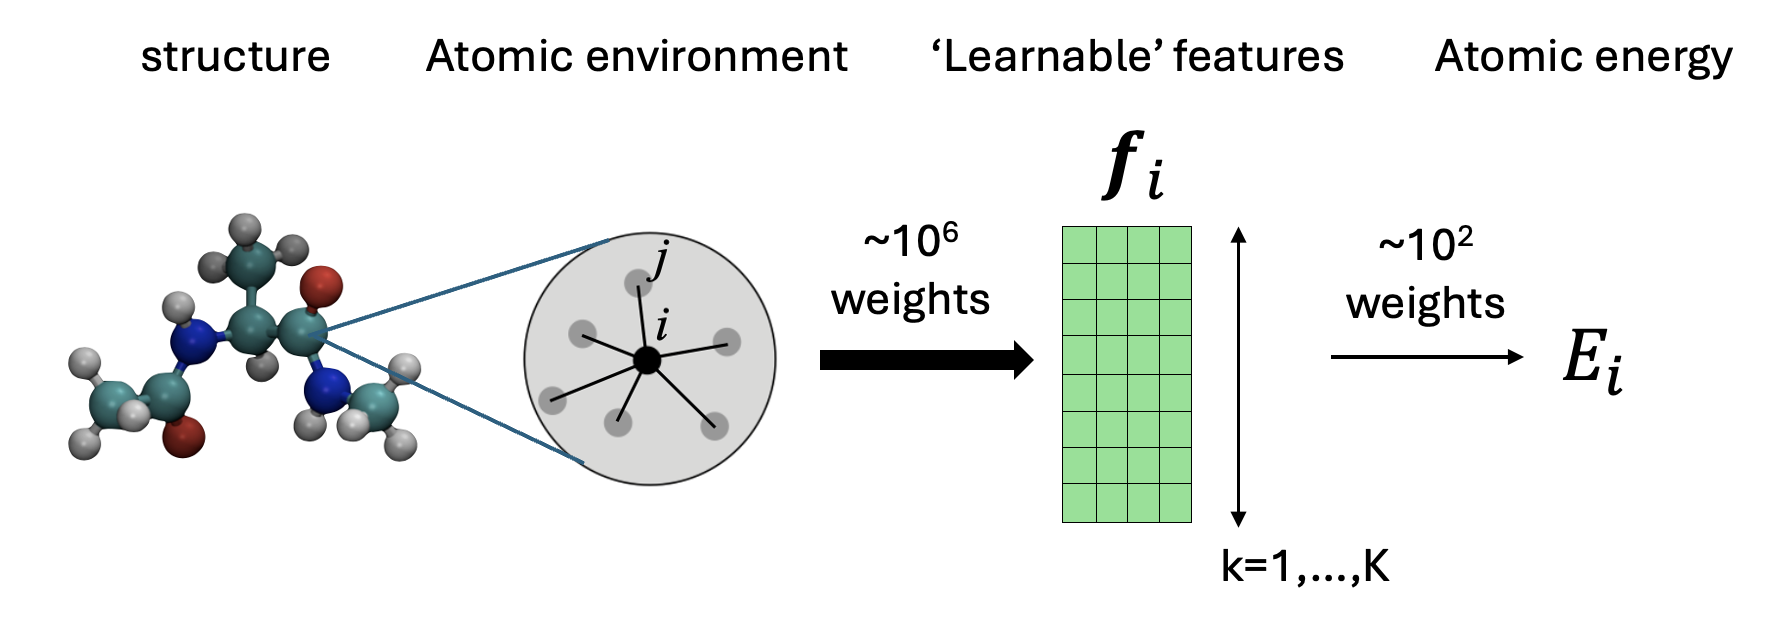

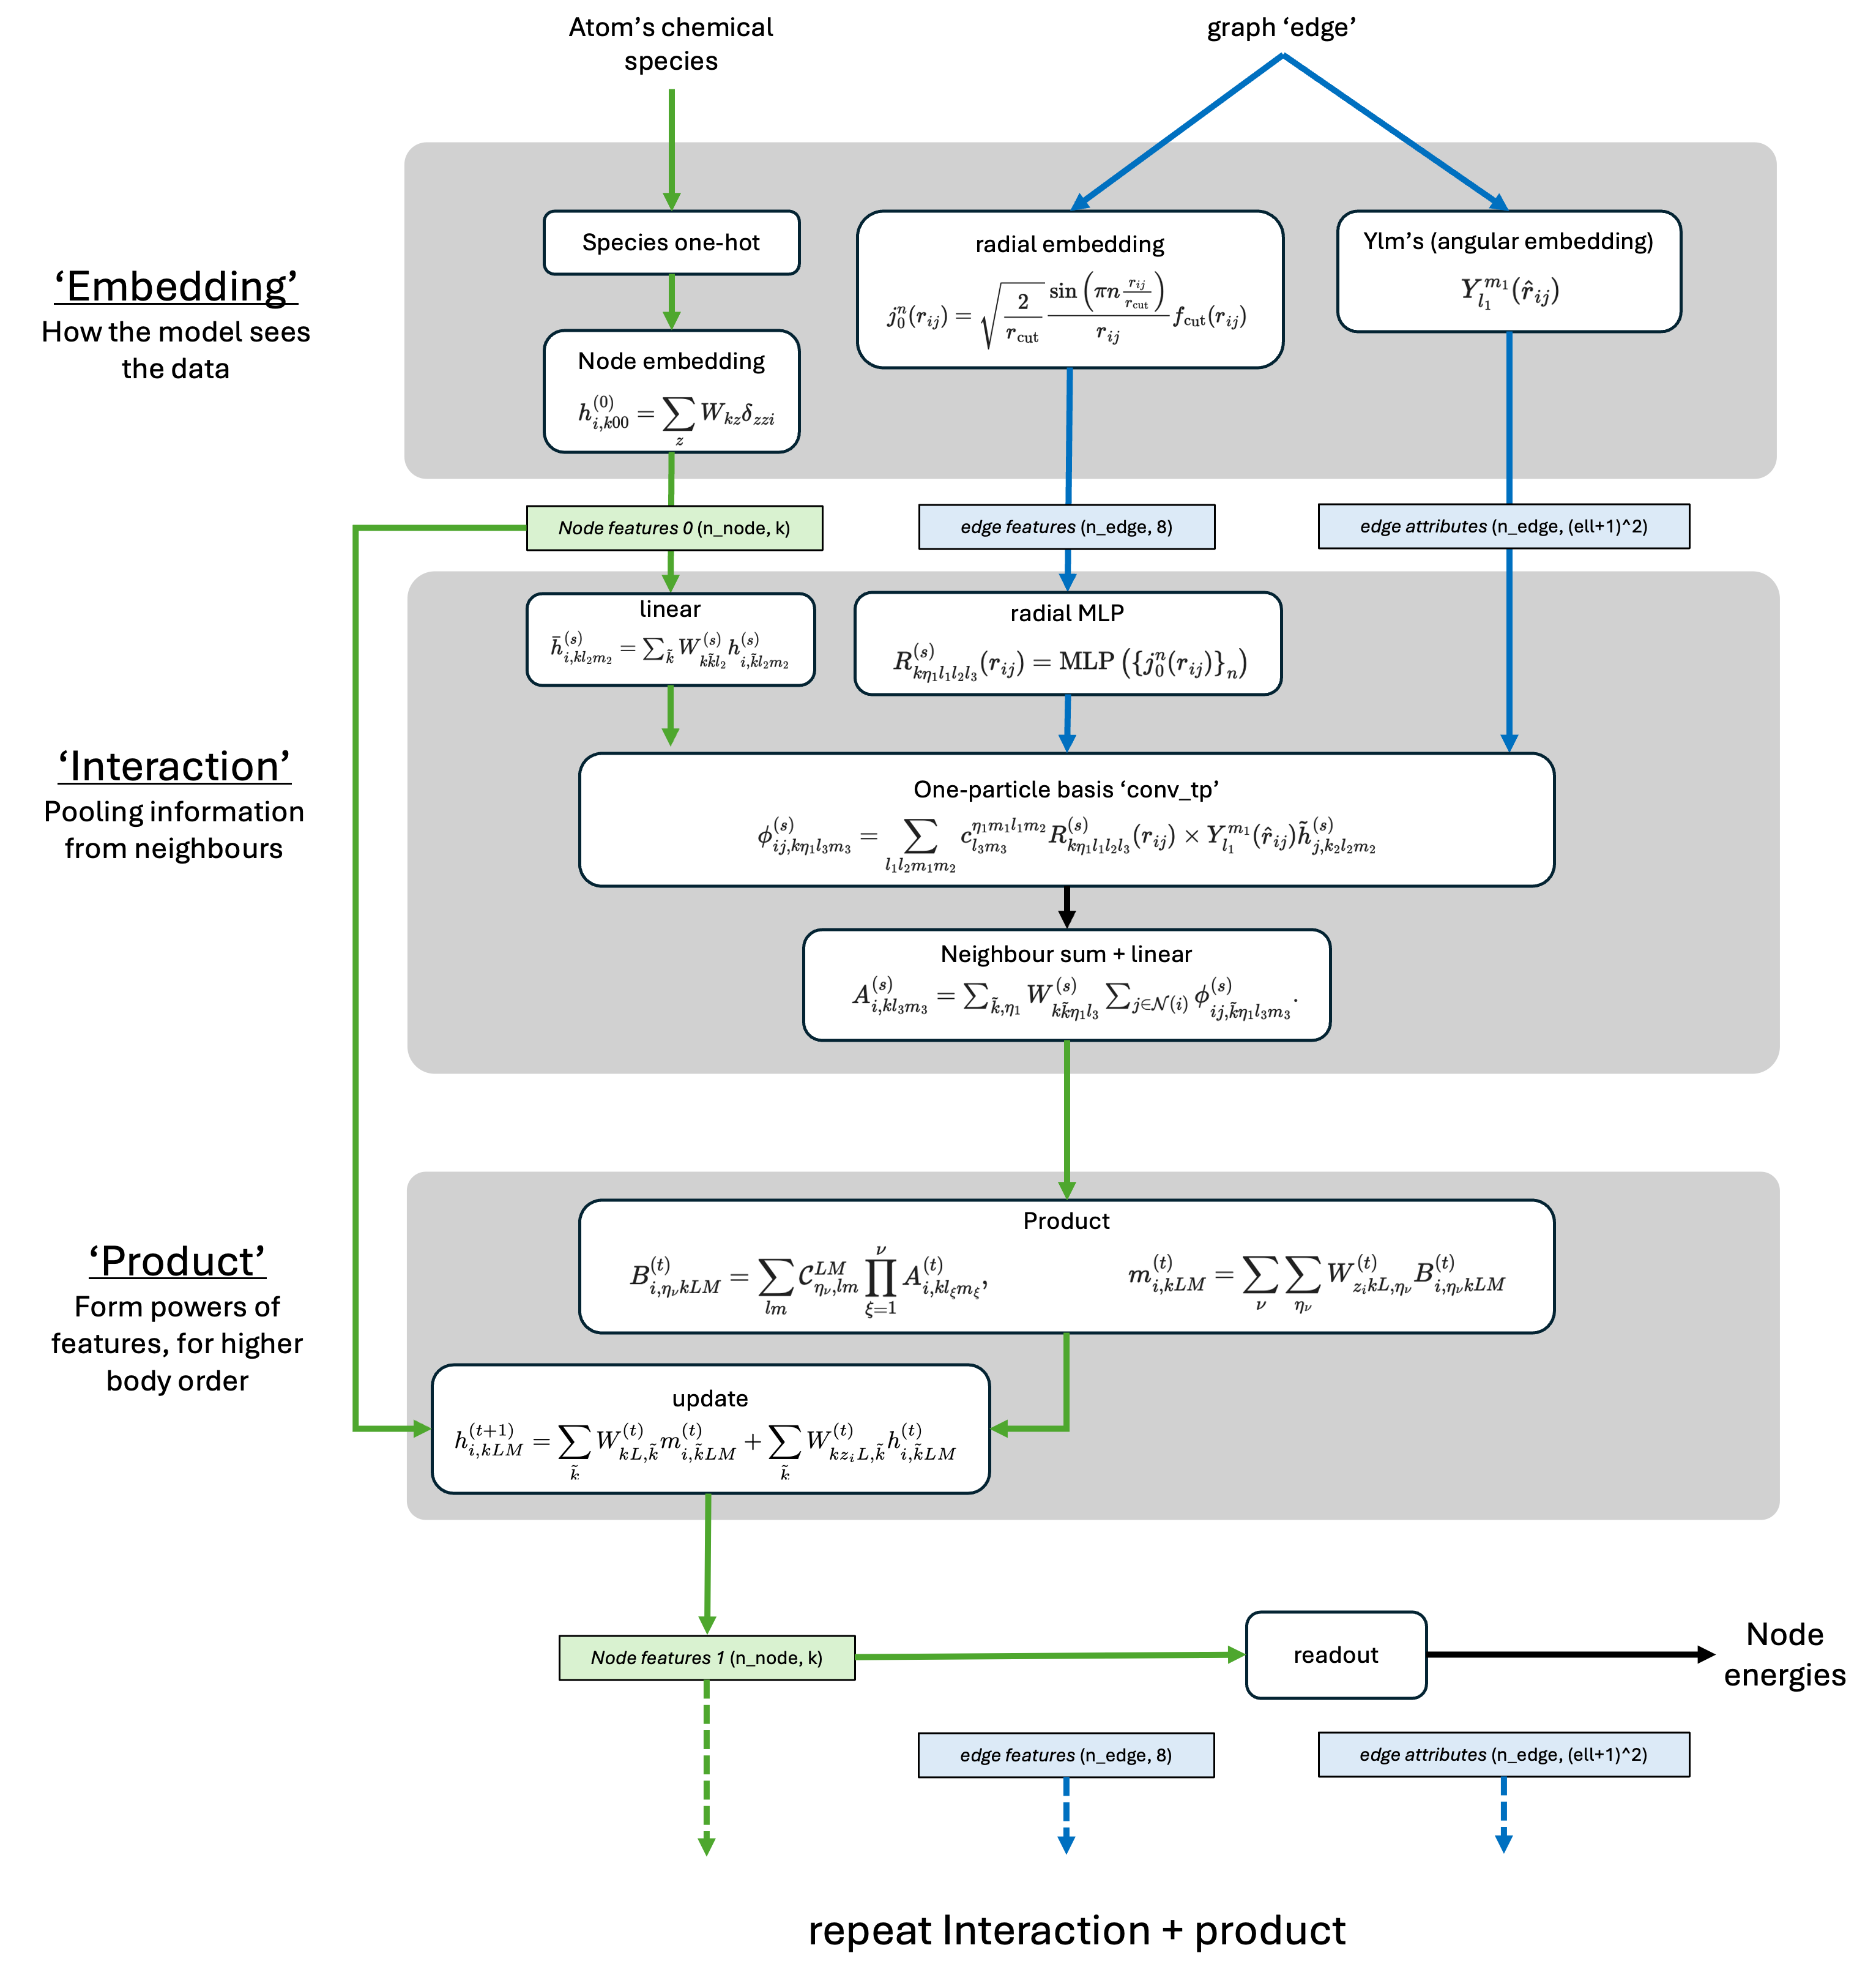

MACE es un potencial interatómico aprendido que aproxima la superficie de energía potencial (PES)

bajo las siguientes simetrías físicas exactas:

**-Invarianza traslacional**

**-Invarianza rotacional (SO(3))**

**-Invarianza por permutación de átomos iguales**

**-Extensividad (la energía escala con el número de átomos)**

Para estas invarianzas la base de esta red se construye sobre los armónicos esféricos, puesto que estos son equivariantes ante rotaciones. De la siguiente forma:

$$ Y_{lm}(R\mathbf{r}) = \sum_{m'} D(R)^l_{mm'} Y_{lm'}(\mathbf{r})$$

MACE implementa esta función como una red neuronal equivarante E(3) inspirada directamente en la Atomic Cluster Expansion (ACE).

Para obtener una cantidad invariante más descriptiva, necesitamos realizar algunas operaciones sobre los armónicos esféricos. Nos interesa cómo cambian los armónicos esféricos cuando se rota la entrada, porque es fácil llevar la cuenta de cómo las rotaciones afectan a estos objetos. Esto significa que también es sencillo volver a obtener una cantidad invariante cuando lo necesitamos. En MACE, y en muchos otros MLIPs, estas matemáticas se realizan mediante un paquete llamado `e3nn`.

`e3nn` proporciona funciones que realizan operaciones sobre tensores esféricos (objetos con componentes como $[Y_{0}^0, Y_{1}^{-1}, Y_{1}^0, \dots]$), manteniendo explícitamente el seguimiento de cómo se comportan bajo rotaciones. Un ejemplo de operación es el producto tensorial, que toma dos arreglos, $A_{lm}$ y $B_{lm}$, y los multiplica para dar como resultado $C_{lm}$:

$$
[A_{lm}] \ \otimes \ [B_{lm}] \ = \ [C_{lm}]
$$

La clave es que $C$ sigue estando indexado por $l$ y $m$, de modo que si observamos la parte con $l = 0$, esta seguirá siendo invariante. Esto significa que podemos realizar muchas operaciones para combinar armónicos esféricos y, posteriormente, construir descriptores invariantes que contienen información angular, como por ejemplo los ángulos entre vectores.

Podemos demostrar esto tomando los dos vectores anteriores, realizando su producto tensorial y conservando únicamente aquellas salidas que son invariantes bajo rotaciones.
Por otro lado se hace uso de la base radial: funciones de Bessel

Para cada arista del grafo atómico se define una función radial basada en las funciones esféricas de Bessel:

$[
R_n(r_{ij}) = j_\ell\!\left( \frac{z_{\ell n}}{r_{\max}} r_{ij} \right) f_{\mathrm{cut}}(r_{ij})
]$

donde:

- $( j_\ell )$ es la función esférica de Bessel de orden $(\ell)$,  
- $( z_{\ell n} )$ es el \(n\)-ésimo cero de $( j_\ell )$,  
- $( r_{ij} = |\mathbf{r}_{ij}| )$ es la distancia interatómica,  
- $( f_{\mathrm{cut}}(r) )$ es una función de corte suave que asegura que la contribución de pares alejados decaiga a cero.


Las funciones radiales $(R_n(r))$ poseen varias propiedades fundamentales para la construcción de descriptores atómicos:

1. **Ortogonalidad**: los diferentes $(R_n)$ son ortogonales bajo la norma adecuada, lo que evita redundancias.  
2. **Suavidad**: permiten gradientes continuos de fuerzas y energías, esenciales para la diferenciabilidad automática.  
3. **Diferenciabilidad**: garantizan que el gradiente $(\nabla_{\mathbf{r}_i} R_n(r_{ij})$ exista, requisito para computar fuerzas físicas consistentes.

En la práctica, la evaluación de $(R_n(r_{ij}))$ se realiza mediante combinaciones de funciones seno y coseno, que aproximan las Bessel de manera eficiente. Estos no se entrenan directamente las Bessel. Solo se entrenan las combinaciones lineales posteriores, que forman los descriptores atómicos invariantes/equivariantes utilizados por MACE.

Luego para la representación en memoria, los valores radiales se almacenan como un arreglo:

$[
R \in \mathbb{R}^{N_r}
]$

donde $(N_r)$ es el número de funciones radiales consideradas para cada arista.

**Comentario físico/geométrico**

Esta construcción garantiza que cada vector relativo $(\mathbf{r}_{ij})$ se proyecte sobre un espacio funcional completo y diferenciable, proporcionando la base para construir descriptores invariantes de orden superior mediante combinaciones con armónicos esféricos y productos tensoriales.


### Embeddings

A continuación, toda la información geométrica y química construida previamente se utiliza para definir las entradas iniciales del modelo MACE. Este proceso se conoce como embedding.

El embedding transforma información discreta (especie química, conectividad) y geométrica (distancias, direcciones) en representaciones tensoriales estructuradas que el modelo puede procesar.

**Concepto clave: “canales” en MACE**

La ecuación que define las características iniciales de los nodos (átomos) es:

$[
h_{i,k00}^{(0)} = \sum_z W_{kz}\, \delta_{z z_i}
]$

donde:

- $( i )$ indexa el átomo,
- $( k )$ indexa el **canal**,
- $( z_i )$ es la especie química del átomo \( i \),
- $( \delta_{z z_i} )$ es el delta de Kronecker,
-$( W_{kz} )$ es una matriz de parámetros entrenables.

**Ejemplo concreto**

Supongamos que el sistema contiene únicamente hidrógeno (H) y carbono (C).
- Si el átomo $( i )$ es hidrógeno, sus características iniciales son simplemente:
  $[
  h_i = W_{k0}
  ]$

- Si el átomo $( i )$ es carbono, entonces:
  $[
  h_i = W_{k1}
  ]$

Es decir, cada átomo recibe un vector de longitud $( K )$ que depende únicamente de su especie química. Aquí el índice $( K )$ se denomina número de “canales”. Este número define el tamaño fundamental del descriptor atómico.


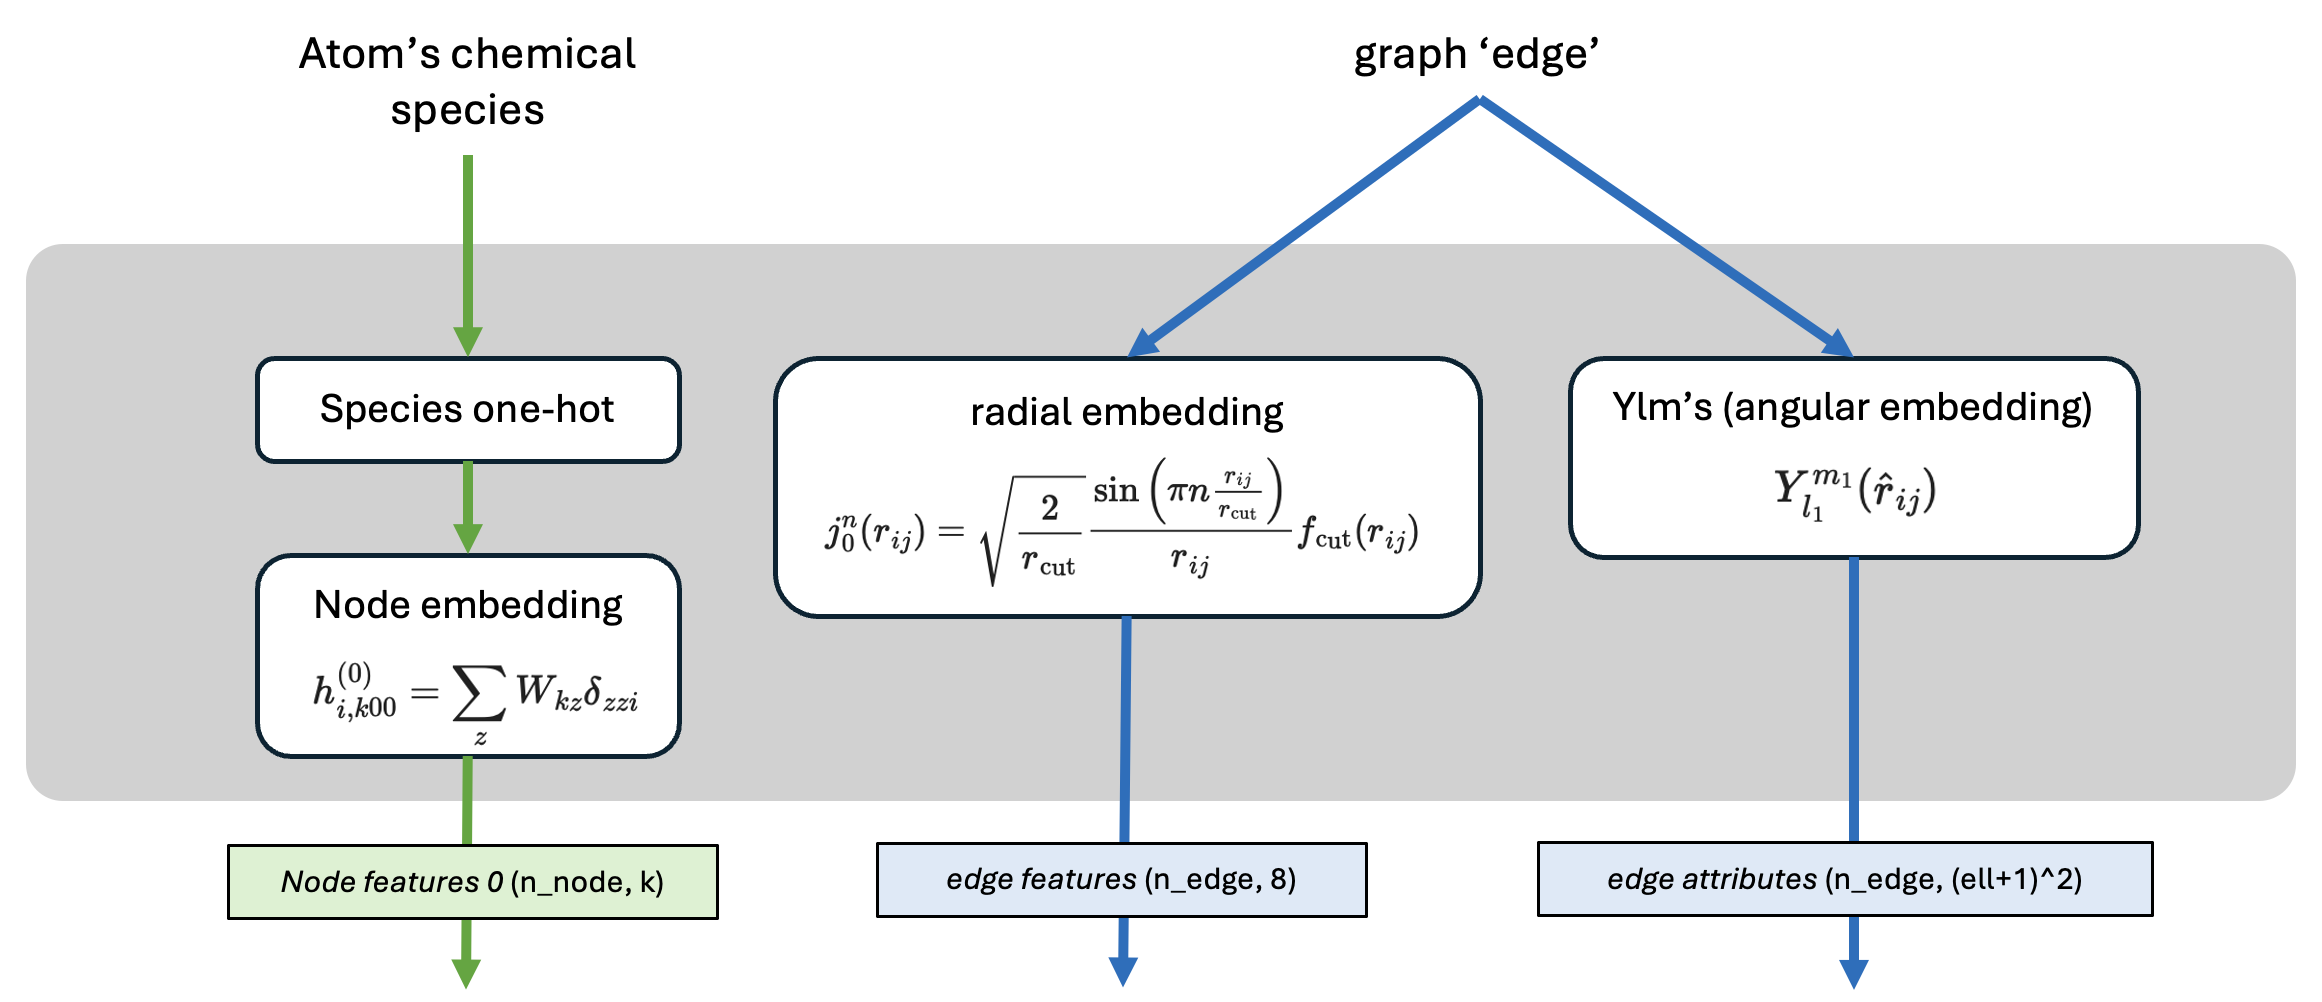

### Representación geométrica: grafos atómicos

Cada configuración atómica se representa como un grafo geométrico, que codifica de manera explícita la estructura local y las relaciones espaciales entre los átomos.

**Componentes del grafo**

- **Nodos**:  
  Cada nodo corresponde a un átomo y porta información intrínseca, como la especie química (número atómico).

- **Aristas**:  
  Se introduce una arista entre dos átomos $( i )$ y $( j $) cuando la distancia entre ellos satisface un criterio geométrico, típicamente
  $[
  |\mathbf{r}_{ij}| < r_{\mathrm{cut}},
  ]$
  donde $( r_{\mathrm{cut}} )$ es un radio de corte que define el entorno local.

**Geometría relativa**

Para cada arista se define el vector de desplazamiento relativo:

$[
\mathbf{r}_{ij} = \mathbf{r}_j - \mathbf{r}_i
]$

Este vector contiene toda la información geométrica relevante:
- su norma $( |\mathbf{r}_{ij}| )$ codifica la distancia interatómica,
- su dirección define la orientación espacial entre los átomos.

En el marco de MACE, estos vectores se interpretan como elementos del espacio tangente y constituyen la entrada geométrica fundamental del modelo.


**Interpretación física y geométrica**

Esta construcción permite describir la estructura atómica como un objeto discreto pero geométricamente consistente, donde:
- la traslación global no altera los vectores relativos,
- la rotación global actúa de manera covariante sobre $( \mathbf{r}_{ij} )$.

Esto garantiza que los descriptores construidos a partir del grafo respeten las simetrías euclídeas del espacio físico $(( E(3) ))$, un requisito esencial para la predicción consistente de energías y fuerzas. En este sentido, el grafo atómico proporciona una discretización geométrica del espacio de configuraciones, sobre la cual se construyen representaciones invariantes y equivariantes utilizadas por MACE.


---
## Construcción de la base geométrica completa

Una vez definidas las bases radial y angular, se construye la base geométrica completa asociada a cada arista del grafo atómico. Esta base codifica simultáneamente la dependencia en distancia y orientación, respetando explícitamente las simetrías rotacionales del espacio físico.

**Base geométrica por arista**

Para cada par de átomos $( i \to j )$, se define la función base como ya se mencionó, contruida con la parte radial y angular:

$[\Phi_{n\ell m}(\vec{r}_{ij})=R_n(r_{ij})\, Y_{\ell m}(\hat{\vec{r}}_{ij})]$

donde:

- $( R_n(r_{ij}) )$ es la función radial,
- $( Y_{\ell m}(\hat{\mathbf{r}}_{ij}) )$ es el armónico esférico evaluado en la dirección unitaria
  $[
  \hat{\mathbf{r}}_{ij} = \frac{\mathbf{r}_{ij}}{|\mathbf{r}_{ij}|},
  ]$
- $( ell )$ y $( m )$ indexan las representaciones irreducibles de $( SO(3) )$.

Esta construcción separa explícitamente radios y ángulos, facilitando la imposición de equivarianza rotacional.

**Implementación computacional**

Desde el punto de vista computacional, la base geométrica se construye mediante:

- **Producto exterior (tensorial)** entre las bases radial y angular,
- **Broadcasting** eficiente para evaluar todas las aristas en paralelo,
- Organización de los datos como tensores estructurados por:
  - orden angular $( \ell )$,
  - paridad $(even / odd)$,
  - multiplicidad.

No se trabaja con tensores planos, sino con estructuras que reflejan directamente la teoría de representaciones.

**Representaciones irreducibles**

En MACE, los embeddings atómicos no son vectores ordinarios, sino sumas directas de representaciones irreducibles de $( SO(3) )$:

$[
h_i = \bigoplus_{\ell} h_i^{(\ell)}
]$

donde cada bloque $( h_i^{(\ell)} )$ transforma como una representación irreducible de orden $( \ell )$.


**Mensaje equivarante**: núcleo de MACE

La operación central de MACE es la propagación de mensajes equivariantes entre nodos del grafo atómico.

**Definición formal**

Para una arista $( i \to j )$, el mensaje se define como:
$[
m_{ij} = h_j \otimes \Phi(\mathbf{r}_{ij})
]$

donde:
- $( h_j )$ es el embedding del átomo emisor,
- $( \Phi(\mathbf{r}_{ij}) )$ es la base geométrica asociada a la arista,
- $( \otimes )$ denota el **producto tensorial equivarante**.

**Descomposición mediante coeficientes de Clebsch–Gordan**

El producto tensorial de dos irreps se descompone según la regla de acoplamiento angular:

$[V_{\ell_1} \otimes V_{\ell_2}=\bigoplus_{\ell = |\ell_1 - \ell_2|}^{\ell_1 + \ell_2} V_{\ell}]$

Esta descomposición está gobernada por los **coeficientes de Clebsch–Gordan**, que aseguran que cada término resultante transforme correctamente bajo rotaciones.

**Implementación numérica**

En la práctica:

- Se utilizan **tablas de Clebsch–Gordan precomputadas**,
- El acoplamiento se implementa mediante:
  - multiplicaciones tensoriales y sumas ponderadas.

Los únicos parámetros entrenables aparecen posteriormente, en las combinaciones lineales de los canales resultantes.

---

## Energía total y gradiente: de invariantes geométricos a fuerzas físicas

La construcción geométrica equivarante culmina en la predicción de una energía total invariante, a partir de la cual se obtienen las fuerzas atómicas como gradientes, garantizando consistencia física exacta.
Luego para se toma la energía como cantidad escalar invariante por construcción, la energía debe ser invariante bajo el grupo euclídeo $( E(3) )$ (rotaciones, traslaciones y permutaciones de átomos idénticos). En MACE, esta condición se impone seleccionando únicamente los canales escalares $((\ell = 0))$ de los embeddings atómicos finales.

Para cada átomo $( i )$, se define una energía local:

$[
E_i = \mathcal{E}\!\left(h_i^{(\ell=0)}\right)
]$

donde:
- $( h_i^{(0)} )$ es el bloque escalar del embedding atómico,
- $( \mathcal{E} )$ es una función aprendida (típicamente una red feed-forward).

La energía total del sistema se obtiene como una suma:

$[
E_{\mathrm{tot}} = \sum_i E_i
]$

Esta descomposición asegura extensividad y simetría permutacional.

**Gradiente de la energía y fuerzas atómicas**

Las fuerzas se definen como el gradiente negativo de la energía con respecto a las posiciones atómicas:

$[
\mathbf{F}_i = - \nabla_{\mathbf{r}_i} E
]$

Dado que la energía depende de las posiciones únicamente a través de:
- los vectores relativos $( \mathbf{r}_{ij} )$,
- las funciones radiales $( R_n(r_{ij}) )$,
- los armónicos esféricos $( Y_{\ell m}(\hat{\mathbf{r}}_{ij}) )$,

el gradiente se propaga mediante la regla de la cadena, respetando la estructura equivarante del modelo. Aquí se debe tener en cuenta la diferenciabilidad y consistencia física

POr lo tanto todas las operaciones en MACE —incluyendo:
- funciones de Bessel
- armónicos esféricos
- productos tensoriales
- combinaciones lineales

son suaves y diferenciables, lo que garantiza que:

- las fuerzas sean continuas
- no aparezcan discontinuidades espurias
- se conserve la relación exacta entre energía y fuerzas

Este punto distingue a los potenciales equivariantes de aproximaciones puramente empíricas. Por lo tanto es útil mencionar el rol de la diferenciación automática en la implementación práctica, el gradiente se calcula mediante diferenciación automática, Por lo que se parametrizan fuerzas de forma independiente, donde se obtienen exclusivamente como derivadas de la energía y con esto se asegura la conservación de energía y la coherencia termodinámica.

**Comentario geométrico y físico**

Desde un punto de vista geométrico:
- la energía define un campo escalar sobre el espacio de configuraciones,
- las fuerzas corresponden al campo gradiente asociado.

Desde el punto de vista físico:
- las trayectorias dinámicas siguen curvas inducidas por este gradiente,
- en ausencia de disipación, el sistema evoluciona conservando energía.

En este sentido, MACE implementa una realización computacional moderna del principio variacional de la mecánica clásica, donde la geometría y la simetría determinan la dinámica.

---

**Resumen conceptual**

- La energía emerge de canales invariantes $(\ell=0)$.
- Las fuerzas se obtienen como gradientes exactos.
- La equivarianza garantiza transformación correcta bajo rotaciones.
- La física no se aprende: **se impone por construcción**.


### Referencia

En este trabajo se empleo como asistente a GPT-5.1 en su versión plus, para correción de códigos y primeros acercamientos a temeas nuevos.

- [1]I. Batatia et al., “A foundation model for atomistic materials chemistry,” The Journal of Chemical Physics, vol. 163, no. 18, Nov. 2025, doi: https://doi.org/10.1063/5.0297006.
‌- [2]I. Batatia, D. P. Kovács, G. N. C. Simm, C. Ortner, and G. Csányi, “MACE: Higher Order Equivariant Message Passing Neural Networks for Fast and Accurate Force Fields,” arXiv.org, Jan. 26, 2023. https://arxiv.org/abs/2206.07697
- [3]“MACE - Machine Learning Force Fields — mace 0.3.13 documentation,” Readthedocs.io, 2025. https://mace-docs.readthedocs.io/en/latest/index.html (accessed Dec. 16, 2025).
- [4]“Atomic Simulation Environment — ASE documentation,” Ase-lib.org, 2019. https://ase-lib.org/index.html (accessed Dec. 16, 2025).
- [5]X. Liu, K. Zeng, Z. Luo, Y. Wang, T. Zhao, and Z. Xu, “Fine-Tuning Universal Machine-Learned Interatomic Potentials: A Tutorial on Methods and Applications,” arXiv (Cornell University), Jun. 2025, doi: https://doi.org/10.48550/arxiv.2506.21935.
- [6]J. Herrera et al., “Revising the Formation of β-Hematin Crystals from Hemin in Aqueous-Acetate Medium Containing Chloroquine: Modeling the Kinetics of Crystallization and Characterizing Their Physicochemical Properties,” Crystal Growth & Design, vol. 23, no. 7, pp. 4791–4806, Jun. 2023, doi: https://doi.org/10.1021/acs.cgd.2c01429.
‌